# GSF Training Model

In [71]:
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem

random.seed(42)

In [72]:

import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    roc_curve,
    auc,
    hamming_loss,
    jaccard_score,
)
import matplotlib.pyplot as plt


# Data Processing

In [8]:
chembl_df = pd.read_csv("../../data/ExperimentData/pChEMBL_data.csv")
print(chembl_df.head())

  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active  


## process the data -> split to psy and non-psy

In [37]:
filtered_df = chembl_df[chembl_df["Comment"] != "Not Determined"]
filtered_df.fillna(0, inplace=True)
print(filtered_df.shape)

# check psy ad non-psy number
psy_chembl = filtered_df[filtered_df["pChEMBL Value"] == 0].drop(["Comment"], axis=1)
non_psy_chembl = filtered_df[filtered_df["pChEMBL Value"] != 0].drop(["Comment"], axis=1)

print(psy_chembl.shape)
print(non_psy_chembl.shape)

combine_psy_nonpsy = filtered_df.drop(["Comment"], axis=1)
print(combine_psy_nonpsy.head())    

(1260, 4)
(314, 3)
(946, 3)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value  
0           8.52  
1           7.40  
2           6.23  
3           0.00  
4           0.00  


/var/folders/qx/gfkzkrms53g36y6nnlpc2t2c0000gn/T/ipykernel_89663/1542438518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna(0, inplace=True)


## Extract group tokan by autofragmentation

In [38]:
# data preparation for fragmenting using X_train
SMILES_autofragmentation = combine_psy_nonpsy["Smiles"].tolist()

print(SMILES_autofragmentation)

['Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1', 'COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1', 'c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1', 'Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CC1', 'Clc1cccc(N2CCNCC2)c1', 'COc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc2c(ccc3cnn(C[C@H](C)N)c32)o1', '[2H]C([2H])([2H])N1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'CN1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'Cl.Oc1ccc(O)c(C2NCCc3c2[nH]c2ccc(F)cc32)c1', 'Clc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1', 'Cl.Oc1ccc(C2NCCc3c2[nH]c2ccc(Cl)cc32)cc1', 'Cl.Fc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1F', 'Cl.Oc1ccccc1C1NCCc2c1[nH]c1ccc(Cl)cc21', 'Cc1noc(C)c1C1NCCc2c1[nH]c1ccc(F)cc21.Cl', 'Cc1cc(C2NCCc3c2[nH]c2ccc(Cl)cc32)sc1Br.Cl', 'CC1CNCCc2cc(F)c(Cl)cc21', 'Oc1cccc2[nH]cc(CCN3CCC3)c12', 'CC1CNCCc2cc(O)c(Br)cc21', 'CC1CNCCc2c(Cl)cccc21', 'Clc1ccccc1O[C@H]1CCCc2ccc(N3CCNCC3)nc21', 'C[C@@H]1CNC[C@H]2Cc3ccc(COCC4CC4)nc3N21', 'CC1CNCCc2ccc(C(F)(F)F)cc21', 'CC

### mmpa

In [39]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in SMILES_autofragmentation]

# extracting a set of reasonable groups using fragmentation
fragments_mmpa = gsf.fragment_mols(molecules, method="mmpa")

# create a dictionary of fragments for tracking
vocab_fragment_mmpa = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments_mmpa)
    ]
)

print(fragments_mmpa)
print(len(fragments_mmpa))


100%|██████████| 1260/1260 [02:52<00:00,  7.30it/s]


['C1C(*1)CN1*1', 'C1=C(OC(*1)*1)C(C2(*1)C[C@@H]2*1)=C(*1)C(*1)=C1*1', 'COC1=CC=C(*1)C=C1C1(*1)CC1*1', 'C1=C(OC(*1)*1)C([C@H]2C[C@@H]2*1)=CC(*1)=C1', 'C1=C(OC(*1)*1)C(C2(*1)C[C@@H]2CN(*1)*1)=C(*1)C(*1)=C1*1', 'COC1=CC=C(*1)C=C1C1(*1)CC1CN*1', 'C1=C(OC*1)C([C@H]2C[C@@H]2CN(*1)*1)=CC(*1)=C1', 'C([C@@H]1C(C2=C(*1)C(*1)=C(*1)C(*1)=C2*1)(*1)C1(*1)*1)N(*1)*1', 'NC[C@H]1C[C@@]1(C1=CC=CC=C1*1)*1', 'C1[C@H](CN(*1)*1)[C@H]1C1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1=CC2=C(C=C1*1)C(*1)=NN2*1', 'N1=C(*1)C2=C(N1)C(*1)=C(*1)C(*1)=C2*1', 'FC1=C(*1)C=C(O*1)C(C2(*1)C[C@@H]2C*1)=C1*1', 'FC1=CC=C(O*1)C([C@@H]2C[C@H]2C*1)=C1', 'C1=C2C(=CC=C1*1)N(*1)N=C2*1', 'C1=C2NN=C(*1)C2=CC(*1)=C1*1', 'C1=C(*1)C2=C(C(*1)=C(*1)C(*1)=C2*1)N1*1', 'C1=C(*1)C2=C(N1)C(*1)=C(*1)C(*1)=C2*1', 'C1=C(C(N(C[C@H]2C[C@@H]2C2=CC(*1)=CC=C2*1)*1)*1)C(*1)=CC=C1*1', 'C1=CC=C(*1)C(CNC[C@H]2CC2(C2=CC(*1)=CC=C2*1)*1)=C1', 'C1=CC=C(C(N(C[C@H]2C[C@@H]2C2=CC(*1)=CC=C2OC*1)*1)*1)C(OC*1)=C1', 'COC1=CC=CC=C1CNCC1CC1(C1=CC(*1)=CC=C1OC)*1', 'C1=CC(*1)=C(*1)

In [40]:
grammar_auto_mmpa = gsf.GroupGrammar(vocab=vocab_fragment_mmpa)

### mmpa fragmentation on chembl data

In [41]:
encode_input = [Chem.MolFromSmiles(smiles) for smiles in combine_psy_nonpsy["Smiles"]]

In [42]:
group_selfie_mmpa = []
extracted_groups_mmpa = []


for smiles in encode_input:
    encode_mol = grammar_auto_mmpa.full_encoder(smiles)
    group_selfie_mmpa.append(encode_mol)
    extracted = grammar_auto_mmpa.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_mmpa.append(extracted_group)
    print(extracted_group)

print(extracted_groups_mmpa)


['frag94', 'frag66', 'frag42']
['frag94', 'frag66', 'frag0', 'frag42']
['frag66', 'frag42', 'frag42']
['frag94']
['frag6']
['frag94']
['frag48']
['frag94', 'frag42']
['frag42']
['frag66']
[]
['frag42']
['frag71']
['frag71']
['frag71']
['frag71']
['frag71']
['frag71']
['frag71', 'frag58']
['frag42']
['frag22']
['frag42']
['frag42']
['frag48']
[]
['frag42']
['frag42']
['frag42']
['frag94', 'frag42']
['frag13']
['frag94', 'frag42']
['frag94', 'frag42']
['frag42']
['frag42']
['frag42']
['frag94']
['frag94']
['frag94']
['frag94']
[]
[]
['frag42']
['frag42']
['frag70', 'frag55']
['frag70', 'frag55']
['frag83']
['frag42']
['frag94', 'frag42']
[]
['frag42']
['frag91']
[]
['frag42']
['frag42']
[]
['frag42']
['frag42']
['frag42']
['frag42']
['frag42']
[]
[]
[]
[]
[]
[]
['frag94']
['frag94']
[]
['frag42']
['frag42']
['frag95']
['frag85']
['frag94']
['frag24', 'frag94']
['frag24', 'frag94']
['frag24']
['frag5', 'frag2']
['frag53']
[]
[]
['frag69']
['frag52']
['frag56']
['frag100']
['frag32']
['fra

### one-hot encoding

In [43]:
# Convert to DataFrame with a single column
df = pd.DataFrame({"Fragments": extracted_groups_mmpa})

# Explode the lists to get one fragment per row
df_exploded = df.explode("Fragments")

# Perform one-hot encoding
one_hot = pd.get_dummies(df_exploded["Fragments"], prefix="frag")

# Group by the original index to aggregate back to list-level encoding
one_hot_encoded = one_hot.groupby(level=0).max().astype(int)

# Print the result
print(one_hot_encoded)
one_hot_encoded.to_csv("psy_nonpsy_onehot.csv")


      frag_frag0  frag_frag100  frag_frag11  frag_frag13  frag_frag14  \
0              0             0            0            0            0   
1              1             0            0            0            0   
2              0             0            0            0            0   
3              0             0            0            0            0   
4              0             0            0            0            0   
...          ...           ...          ...          ...          ...   
1255           0             0            0            0            0   
1256           0             0            0            0            0   
1257           0             0            0            0            0   
1258           0             0            0            0            0   
1259           0             0            0            0            0   

      frag_frag15  frag_frag16  frag_frag2  frag_frag20  frag_frag21  ...  \
0               0            0           0    

# Training

In [67]:
X = one_hot_encoded
y_label = (combine_psy_nonpsy["pChEMBL Value"] > 0).astype(int)
y_value = combine_psy_nonpsy["pChEMBL Value"]


print(X.shape, y_label.shape, y_value.shape)
print(X.head())
print(y_label.head())


(1260, 62) (1260,) (1260,)
   frag_frag0  frag_frag100  frag_frag11  frag_frag13  frag_frag14  \
0           0             0            0            0            0   
1           1             0            0            0            0   
2           0             0            0            0            0   
3           0             0            0            0            0   
4           0             0            0            0            0   

   frag_frag15  frag_frag16  frag_frag2  frag_frag20  frag_frag21  ...  \
0            0            0           0            0            0  ...   
1            0            0           0            0            0  ...   
2            0            0           0            0            0  ...   
3            0            0           0            0            0  ...   
4            0            0           0            0            0  ...   

   frag_frag85  frag_frag87  frag_frag88  frag_frag89  frag_frag91  \
0            0            0          

### Single Label

In [62]:
# Nested cross-validation setup
outer_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(accuracy_score, greater_is_better=True)
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return cv_scores.mean()


[I 2025-01-10 15:16:51,670] A new study created in memory with name: no-name-6e610f53-0b4d-41c2-b2bb-d74e6d4d274c
[I 2025-01-10 15:16:52,100] Trial 0 finished with value: 0.8164770208364119 and parameters: {'n_estimators': 59, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.8164770208364119.
[I 2025-01-10 15:16:52,173] Trial 1 finished with value: 0.80158612876213 and parameters: {'n_estimators': 17, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.8164770208364119.
[I 2025-01-10 15:16:52,264] Trial 2 finished with value: 0.7916654352002365 and parameters: {'n_estimators': 26, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.8164770208364119.
[I 2025-01-10 15:16:52,569] Trial 3 finished with value: 0.795640608837003 and parameters: {'n_estimators': 81, 'max_depth': 8, 'min_samples_split': 5,

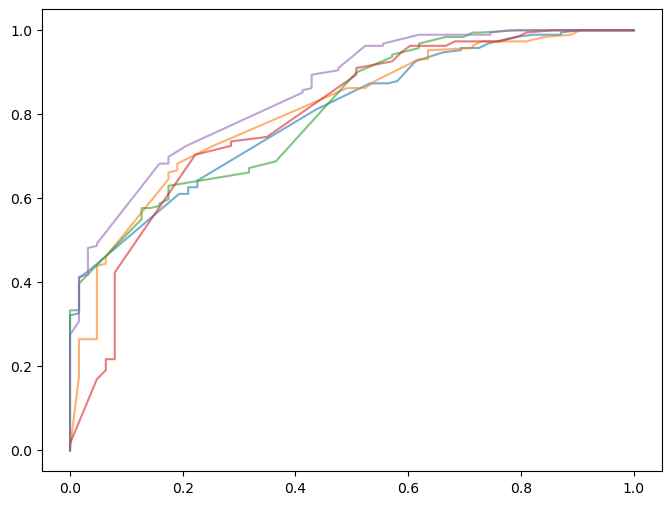

In [68]:
# Outer loop: Statistical evaluation
outer_scores = []
# ncv_label_scores = {label: [] for label in y.columns}

# For ROC plotting
mean_fpr = np.linspace(0, 1, 100)  # Average FPR for interpolation
tprs = []  # TPRs for all folds
aucs = []  # AUC scores for all folds

plt.figure(figsize=(8, 6))  # Initialize the plot

for fold, (train_index, test_index) in enumerate(outer_ncv.split(X, y_label), start=1):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_label.iloc[train_index], y_label.iloc[test_index]

    # Skip fold if only one class is present
    if len(np.unique(y_test)) < 2:
        print(
            f"Fold {fold}: Only one class present in y_test. Skipping ROC computation."
        )
        continue

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = best_rf_classifier.predict(X_test)
    y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "f1_score": f1_score(y_test, y_test_pred, average="weighted"),
        }
    )


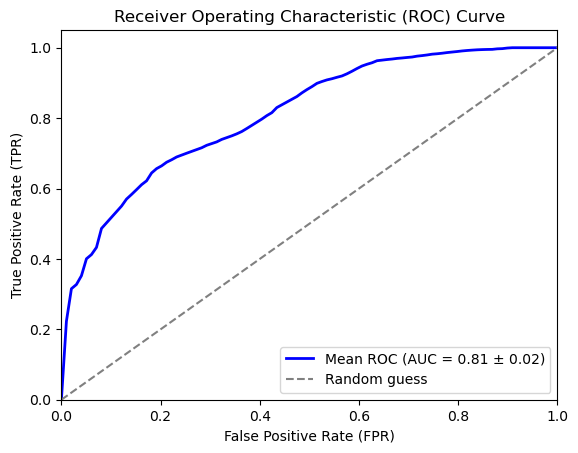

Accuracy: Mean = 0.81, Std = 0.01
F1_score: Mean = 0.78, Std = 0.02


In [69]:
# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )


### Real Value Threshold

In [ ]:
# Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    threshold = trial.suggest_float("threshold", 0, 5)  # Threshold for binary classification

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    inner_scores = []
    # Evaluate using inner CV
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        rf.fit(X_train_inner, y_train_inner)

        # Predict real values
        y_pred_inner = rf.predict(X_val_inner)

        # Apply threshold to convert real values to binary classification
        y_pred_inner_bool = (y_pred_inner >= threshold).astype(int)
        y_val_inner_bool = (y_val_inner >= threshold).astype(int)

        # Calculate Hamming Loss
        accuracy_inner = accuracy_score(y_val_inner_bool, y_pred_inner_bool)

        # Append score
        inner_scores.append(accuracy_inner)

    return np.mean(inner_scores)



# Outer loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_value.iloc[train_idx], y_value.iloc[test_idx]

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)

    # Apply optimized threshold for classification
    threshold = study.best_trial.params["threshold"]
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)

    # Classification metrics

    # Store all scores
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test_binary, y_pred_binary),
            "f1_score": f1_score(y_test_binary, y_pred_binary, average="weighted"),
        }
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")# Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    threshold = trial.suggest_float("threshold", 0, 5)  # Threshold for binary classification

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    inner_scores = []
    # Evaluate using inner CV
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        rf.fit(X_train_inner, y_train_inner)

        # Predict real values
        y_pred_inner = rf.predict(X_val_inner)

        # Apply threshold to convert real values to binary classification
        y_pred_inner_bool = (y_pred_inner >= threshold).astype(int)
        y_val_inner_bool = (y_val_inner >= threshold).astype(int)

        # Calculate Hamming Loss
        accuracy_inner = accuracy_score(y_val_inner_bool, y_pred_inner_bool)

        # Append score
        inner_scores.append(accuracy_inner)

    return np.mean(inner_scores)



# Outer loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_value.iloc[train_idx], y_value.iloc[test_idx]

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)

    # Apply optimized threshold for classification
    threshold = study.best_trial.params["threshold"]
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)

    # Classification metrics

    # Store all scores
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test_binary, y_pred_binary),
            "f1_score": f1_score(y_test_binary, y_pred_binary, average="weighted"),
        }
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")

[I 2025-01-10 16:10:58,820] A new study created in memory with name: no-name-c4431ec2-4020-440e-946b-d6f5da661554


[I 2025-01-10 16:10:59,254] Trial 0 finished with value: 0.8035860302448155 and parameters: {'n_estimators': 59, 'max_depth': 20, 'min_samples_split': 4, 'threshold': 2.099829361698769}. Best is trial 0 with value: 0.8035860302448155.
[I 2025-01-10 16:10:59,653] Trial 1 finished with value: 0.772838776414955 and parameters: {'n_estimators': 80, 'max_depth': 10, 'min_samples_split': 5, 'threshold': 0.2989165509715247}. Best is trial 1 with value: 0.772838776414955.
[I 2025-01-10 16:11:00,526] Trial 2 finished with value: 0.7797793212157036 and parameters: {'n_estimators': 166, 'max_depth': 10, 'min_samples_split': 9, 'threshold': 1.4546354197709026}. Best is trial 1 with value: 0.772838776414955.
[I 2025-01-10 16:11:01,449] Trial 3 finished with value: 0.7033988473474213 and parameters: {'n_estimators': 139, 'max_depth': 20, 'min_samples_split': 2, 'threshold': 4.9922194335001455}. Best is trial 3 with value: 0.7033988473474213.
[I 2025-01-10 16:11:02,023] Trial 4 finished with value: 0

Fold 1:
  accuracy: 0.6667
  f1_score: 0.6840
Fold 2:
  accuracy: 0.7183
  f1_score: 0.7329
Fold 3:
  accuracy: 0.6984
  f1_score: 0.7157
Fold 4:
  accuracy: 0.7143
  f1_score: 0.7418
Fold 5:
  accuracy: 0.7103
  f1_score: 0.7272


[I 2025-01-10 16:29:11,916] A new study created in memory with name: no-name-b2ef407f-4c2e-44e1-b506-bc056a5b404a
[I 2025-01-10 16:29:12,294] Trial 0 finished with value: 0.8055662282646174 and parameters: {'n_estimators': 51, 'max_depth': 20, 'min_samples_split': 6, 'threshold': 2.3716963367658845}. Best is trial 0 with value: 0.8055662282646174.
[I 2025-01-10 16:29:13,413] Trial 1 finished with value: 0.7747992709718734 and parameters: {'n_estimators': 163, 'max_depth': None, 'min_samples_split': 9, 'threshold': 4.572212414750344}. Best is trial 1 with value: 0.7747992709718734.
[I 2025-01-10 16:29:14,706] Trial 2 finished with value: 0.8065957342002857 and parameters: {'n_estimators': 187, 'max_depth': None, 'min_samples_split': 5, 'threshold': 3.2152290710929474}. Best is trial 1 with value: 0.7747992709718734.
[I 2025-01-10 16:29:15,264] Trial 3 finished with value: 0.7986256834638688 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 4, 'threshold': 1.2137

Fold 1:
  accuracy: 0.6667
  f1_score: 0.6840
Fold 2:
  accuracy: 0.7579
  f1_score: 0.6612
Fold 3:
  accuracy: 0.6984
  f1_score: 0.7157
Fold 4:
  accuracy: 0.7976
  f1_score: 0.7078
Fold 5:
  accuracy: 0.7698
  f1_score: 0.7675


[I 2025-01-10 16:32:00,198] Trial 0 finished with value: 0.8006157332151126 and parameters: {'n_estimators': 173, 'max_depth': None, 'min_samples_split': 3, 'threshold': 2.7878748103045465}. Best is trial 0 with value: 0.8006157332151126.
[I 2025-01-10 16:32:00,830] Trial 1 finished with value: 0.8036057337076992 and parameters: {'n_estimators': 92, 'max_depth': None, 'min_samples_split': 6, 'threshold': 3.155347276037967}. Best is trial 0 with value: 0.8006157332151126.
[I 2025-01-10 16:32:01,303] Trial 2 finished with value: 0.800596029752229 and parameters: {'n_estimators': 98, 'max_depth': 10, 'min_samples_split': 5, 'threshold': 3.670973979850123}. Best is trial 2 with value: 0.800596029752229.
[I 2025-01-10 16:32:01,918] Trial 3 finished with value: 0.801635387419339 and parameters: {'n_estimators': 104, 'max_depth': 20, 'min_samples_split': 4, 'threshold': 3.6725283754165616}. Best is trial 2 with value: 0.800596029752229.
[I 2025-01-10 16:32:02,435] Trial 4 finished with value:

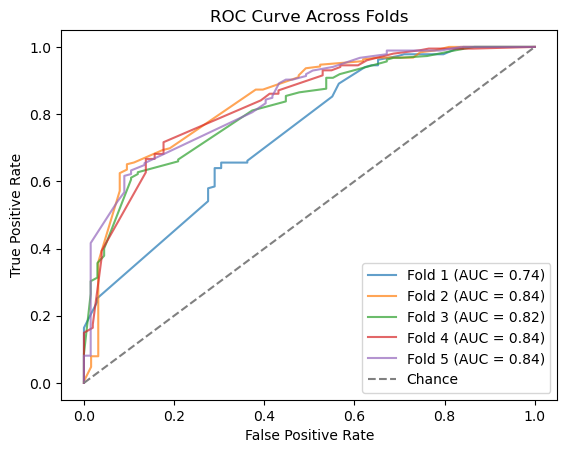

Fold 1:
  accuracy: 0.6667
  f1_score: 0.6840
  roc_auc: 0.7385
Fold 2:
  accuracy: 0.7143
  f1_score: 0.7334
  roc_auc: 0.8440
Fold 3:
  accuracy: 0.6984
  f1_score: 0.7157
  roc_auc: 0.8192
Fold 4:
  accuracy: 0.7381
  f1_score: 0.7622
  roc_auc: 0.8352
Fold 5:
  accuracy: 0.7103
  f1_score: 0.7272
  roc_auc: 0.8423
Fold 1:
  accuracy: 0.6667
  f1_score: 0.6840
  roc_auc: 0.7385
Fold 2:
  accuracy: 0.7143
  f1_score: 0.7334
  roc_auc: 0.8440
Fold 3:
  accuracy: 0.6984
  f1_score: 0.7157
  roc_auc: 0.8192
Fold 4:
  accuracy: 0.7381
  f1_score: 0.7622
  roc_auc: 0.8352
Fold 5:
  accuracy: 0.7103
  f1_score: 0.7272
  roc_auc: 0.8423


In [86]:
# Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    threshold = trial.suggest_float(
        "threshold", 0, 5
    )  # Threshold for binary classification

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    inner_scores = []
    # Evaluate using inner CV
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        rf.fit(X_train_inner, y_train_inner)

        # Predict real values
        y_pred_inner = rf.predict(X_val_inner)

        # Apply threshold to convert real values to binary classification
        y_pred_inner_bool = (y_pred_inner >= threshold).astype(int)
        y_val_inner_bool = (y_val_inner >= threshold).astype(int)

        # Calculate Hamming Loss
        accuracy_inner = accuracy_score(y_val_inner_bool, y_pred_inner_bool)

        # Append score
        inner_scores.append(accuracy_inner)

    return np.mean(inner_scores)


# Outer loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_value.iloc[train_idx], y_value.iloc[test_idx]

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)

    # Apply optimized threshold for classification
    threshold = study.best_trial.params["threshold"]
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)

    # Classification metrics

    # Store all scores
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test_binary, y_pred_binary),
            "f1_score": f1_score(y_test_binary, y_pred_binary, average="weighted"),
        }
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")  # Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    threshold = trial.suggest_float(
        "threshold", 0, 5
    )  # Threshold for binary classification

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    inner_scores = []
    # Evaluate using inner CV
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        rf.fit(X_train_inner, y_train_inner)

        # Predict real values
        y_pred_inner = rf.predict(X_val_inner)

        # Apply threshold to convert real values to binary classification
        y_pred_inner_bool = (y_pred_inner >= threshold).astype(int)
        y_val_inner_bool = (y_val_inner >= threshold).astype(int)

        # Calculate Hamming Loss
        accuracy_inner = accuracy_score(y_val_inner_bool, y_pred_inner_bool)

        # Append score
        inner_scores.append(accuracy_inner)

    return np.mean(inner_scores)


# Outer loop
for fold, (train_idx, test_idx) in enumerate(
    outer_cv.split(X), 1
):  
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_value.iloc[train_idx], y_value.iloc[test_idx]

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)

    # Apply optimized threshold for classification
    threshold = study.best_trial.params["threshold"]
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)

    # Classification metrics
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    f1 = f1_score(y_test_binary, y_pred_binary, average="weighted")

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)  # 使用连续预测值计算 ROC
    roc_auc = auc(fpr, tpr)

    # Store all scores
    outer_scores.append(
        {
            "accuracy": accuracy,
            "f1_score": f1,
            "roc_auc": roc_auc,
        }
    )

    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})", alpha=0.7)

# Finalize ROC plot
plt.plot(
    [0, 1], [0, 1], linestyle="--", color="gray", label="Chance"
)  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Across Folds")
plt.legend(loc="lower right")
plt.show()

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


In [83]:
print(best_params)

{'n_estimators': 98, 'max_depth': 20, 'min_samples_split': 7, 'threshold': 4.976036778419654}


In [ ]:
# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
